<a href="https://colab.research.google.com/github/Bendidi/My_python/blob/main/DarijaBERT_Dialect_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a an example notebook describing the different steps to finetune DarijaBERT on Dialect Identification Task.

Dataset: [MSDA](https://msda.um6p.ma/msda_datasets)

# Libraries

In [ ]:
!pip install transformers

In [ ]:
#options
#pd.set_option("mode.chained_assignment", None)

#Libraries
import pandas as pd
import numpy as np
import scipy
import  os
import random
import time
import datetime
import nltk



nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer,AutoTokenizer, AutoModel


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import itertools
import re





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install pyarabic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 10.4 MB/s eta 0:00:00


In [ ]:
from pyarabic.araby import strip_tatweel,strip_tashkeel

# Data

**Please download the MSDA dataset and then import it like in the next cell**

In [ ]:
MSDA=pd.read_csv("MTCD.csv")

In [ ]:
MSDA.head()

,text,labels
0,خويا نصيحة مني. كمل فخدمتك ومتديهاش فكلام ناس ...,News
1,ضربناكم كاملين ١😂🖕🇲🇦🇲🇦🇲🇦🇲🇦,Sport
2,بغيت نشارك فشي مسابقة حيت عندي 90 فتخفيض,Gaming
3,چاتني 92ف10,Gaming
4,USER angel \nجواب العياشة هوا لي كلتي دابا,News


In [ ]:
#MSDA.dialect.value_counts()
labels = MSDA['labels'].value_counts()
print(labels)
print("Total comments - ", labels.sum())

labels
News       20443
Sport      20000
Gaming     13746
Kitchen    10033
Name: count, dtype: int64
Total comments -  64222


In [ ]:
#Since we'er dealing with four labels
MSDA['labels'] = np.where(MSDA['labels'] == 'News', 0,
                         np.where(MSDA['labels'] == 'Sport', 1,
                                  np.where(MSDA['labels'] == 'Gaming', 2,
                                           np.where(MSDA['labels'] == 'Kitchen', 3, -1))))

#Transform to binary dataset (Moroccan Vs others) and recode to 1/0
#MSDA['labels']=np.where(MSDA.dialect=="Morocco",1,0)

In [ ]:
MSDA.rename(columns={'Twits':'tweet'},inplace=True)

In [ ]:
MSDA.drop(columns='dialect',inplace=True)

## Preprocessing

In [ ]:

def repted(text):

    text=re.sub(r'(.)\1+', r'\1', text) # Replace with only one (remove repetitions)
    return text
def pre_processing(df,field):
    df[field] = df[field].replace(r'http\S+', 'URL', regex=True).replace(r'www\S+', 'URL', regex=True)  # Replace URLs with URL string
    df[field] = df[field].replace(r'@[^\s]+', 'USER', regex=True) # Replace user mentions with USER string
    df[field] = df[field].replace(r'#[^\s]+', 'HASHTAG', regex=True) # Replace Hashtags with HASHTAG string

    df=df[df[field].apply(lambda x:len(re.findall(r'[\u0600-\u06FF]+', x)))>1] #Keep sequences with at least 2 arabic words
    df[field] = df[field].apply(strip_tatweel) #Remove Tatweel string
    df[field] = df[field].apply(strip_tashkeel) # Remove Diacritics
    df[field] = df[field].apply(repted)

    return df

In [ ]:
MSDA_prc=pre_processing(MSDA,'text')

<ipython-input-46-6eb10d45e244>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[field] = df[field].apply(strip_tatweel) #Remove Tatweel string
<ipython-input-46-6eb10d45e244>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[field] = df[field].apply(strip_tashkeel) # Remove Diacritics
<ipython-input-46-6eb10d45e244>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

## Train Test split

In [ ]:
#Specify which Data to use
Data=MSDA_prc.copy()

In [ ]:
#train,valid,train_y,valid_y=train_test_split(Data.tweet.values,Data.labels,test_size=0.2,random_state=42,stratify=Data.labels,)
train,valid,train_y,valid_y=train_test_split(Data.text.values,Data.labels,test_size=0.2,random_state=42,stratify=Data.labels,)

In [ ]:
dev,test,dev_y,test_y=train_test_split(valid,valid_y,test_size=0.5,random_state=42,stratify=valid_y)

##Variables to be used in the training functions

In [ ]:
train_labels=train_y.values
train_tweets=train

In [ ]:
dev_labels=dev_y.values
dev_tweets=dev

In [ ]:
test_labels=test_y.values
test_tweets=test

# GPU device

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# Helper Functions

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Function to calculate the F1-score of our predictions vs labels
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,pred_flat)

In [ ]:

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# Training Functions

### Tokenization

In [ ]:
#Function doing the Bert tokenizer with pading
def Tweets_Tokenizer(tweets,max_len=128):
  # Tokenize all of the sentences and map the tokens to their word IDs.
  input_ids = []
  # Create attention masks
  attention_masks = []
  MAX_LEN = max_len


  # For every sentence...
  for tweet in tweets:


      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          tweet,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                          # This function also supports truncation and conversion
                          # to pytorch tensors, but we need to do padding, so we
                          # can't use these features :( .
                          max_length = MAX_LEN,          # Truncate all sentences.
                          truncation=True
                          #return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent)

  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",value=0, truncating="post", padding="post",)

    # For each sentence...
  for sent in input_ids:


    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

  print('\n Tokenizer is Done.')

  return (input_ids,attention_masks)



### Training

In [ ]:

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
def train_final(data,LR=2e-5,nepochs=3,Batches=16):
  # Number of training epochs (authors recommend between 2 and 4)
  epochs = nepochs

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42
  batch_size = Batches

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)



  # Use 90% for training and 10% for validation.
  input_ids,attention_masks=Tweets_Tokenizer(train_tweets)
  # tr_inputs, validation_inputs, tr_labels, validation_labels = train_test_split(input_ids, train_labels,
  #                                                           random_state=2018, test_size=0.1)
  # # Do the same for the masks.
  # train_masks, validation_masks, _, _ = train_test_split(attention_masks, train_labels,
  #                                            random_state=2018, test_size=0.1)

  # Convert all inputs and labels into torch tensors, the required datatype
  # for our model.
  train_inputs = torch.tensor(input_ids)
  #validation_inputs = torch.tensor(validation_inputs)

  tr_labels = torch.tensor(train_labels)
  #validation_labels = torch.tensor(validation_labels)

  train_masks = torch.tensor(attention_masks)
  #validation_masks = torch.tensor(validation_masks)

  # Create the DataLoader for our training set.
  train_data = TensorDataset(train_inputs, train_masks, tr_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for our validation set.
  # validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  # validation_sampler = SequentialSampler(validation_data)
  # validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


  # Load BertForSequenceClassification, the pretrained BERT model with a single
  # linear classification layer on top.
  model = BertForSequenceClassification.from_pretrained(
    bert_repo, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
    )




  # Tell pytorch to run this model on the GPU.
  model.cuda()

  # Note: AdamW is a class from the huggingface library (as opposed to pytorch)
  # I believe the 'W' stands for 'Weight Decay fix"
  optimizer = AdamW(model.parameters(),
                  lr = LR, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


  # Total number of training steps is number of batches * number of epochs.
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

  # Store the average loss after each epoch so we can plot them.
  loss_values = []

  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_loss = 0

      # Put the model into training mode. Don't be mislead--the call to
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because
          # accumulating the gradients is "convenient while training RNNs".
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()

          # Perform a forward pass (evaluate the model on this training batch).
          # This will return the loss (rather than the model output) because we
          # have provided the `labels`.
          # The documentation for this `model` function is here:
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      labels=b_labels.to(device=device, dtype=torch.int64))

          # The call to `model` always returns a tuple, so we need to pull the
          # loss value out of the tuple.
          loss = outputs[0]

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value
          # from the tensor.
          total_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over the training data.
      avg_train_loss = total_loss / len(train_dataloader)

      # Store the loss value for plotting the learning curve.
      loss_values.append(avg_train_loss)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


  print("")
  print("Training complete!")

  return model

### Prediction function

In [ ]:
def dev_pred(model,tweets,labels):
  dev_inputs, dev_masks = Tweets_Tokenizer(tweets)

  # Convert to tensors.
  prediction_inputs = torch.tensor(dev_inputs)
  prediction_masks = torch.tensor(dev_masks)
  prediction_labels = torch.tensor(labels)

  # Set the batch size.
  batch_size = 64

  # Create the DataLoader.
  prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  # Prediction on test set

  print('Predicting labels for {:,} sentences...'.format(len(prediction_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Predict
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)



  # Combine the predictions for each batch into a single list of 0s and 1s.
  flat_predictions = [item for sublist in predictions for item in sublist]
  Last_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = [item for sublist in true_labels for item in sublist]


  indiv_F1=f1_score(flat_true_labels, Last_predictions, average='weighted') * 100
  macro_F1=f1_score(flat_true_labels, Last_predictions,average='macro')*100


  print("\nF1 Score on positive: %.2f" %indiv_F1, "%")
  #print(indiv_F1)

  return (flat_predictions,Last_predictions,flat_true_labels)

# Running Models

In [ ]:

#https://github.com/alisafaya/Arabic-BERT
tokenizer_DarijaBert = AutoTokenizer.from_pretrained("Kamel/DarijaBERT")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
tokenizer=tokenizer_DarijaBert
bert_repo="Kamel/DarijaBERT"

In [ ]:
model_final=train_final(train,Batches=64,nepochs=1)


 Tokenizer is Done.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Kamel/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 1 ========
Training...
  Batch    40  of    803.    Elapsed: 0:00:49.
  Batch    80  of    803.    Elapsed: 0:01:36.
  Batch   120  of    803.    Elapsed: 0:02:24.
  Batch   160  of    803.    Elapsed: 0:03:12.
  Batch   200  of    803.    Elapsed: 0:04:00.
  Batch   240  of    803.    Elapsed: 0:04:48.
  Batch   280  of    803.    Elapsed: 0:05:36.
  Batch   320  of    803.    Elapsed: 0:06:24.
  Batch   360  of    803.    Elapsed: 0:07:11.
  Batch   400  of    803.    Elapsed: 0:07:59.
  Batch   440  of    803.    Elapsed: 0:08:47.
  Batch   480  of    803.    Elapsed: 0:09:35.
  Batch   520  of    803.    Elapsed: 0:10:23.
  Batch   560  of    803.    Elapsed: 0:11:11.
  Batch   600  of    803.    Elapsed: 0:11:58.
  Batch   640  of    803.    Elapsed: 0:12:46.
  Batch   680  of    803.    Elapsed: 0:13:34.
  Batch   720  of    803.    Elapsed: 0:14:22.
  Batch   760  of    803.    Elapsed: 0:15:10.
  Batch   800  of    803.    Elapsed: 0:15:58.

  Average traini

# Prediction

In [ ]:
flat_predictions,Last_predictions,flat_true_labels=dev_pred(model_final,dev_tweets,dev_labels)


 Tokenizer is Done.
Predicting labels for 6,422 sentences...

F1 Score on positive: 91.12 %


In [ ]:
flat_predictions,Last_predictions,flat_true_labels=dev_pred(model_final,test_tweets,test_labels)


 Tokenizer is Done.
Predicting labels for 6,423 sentences...

F1 Score on positive: 90.75 %


In [ ]:
import matplotlib.pyplot as plt

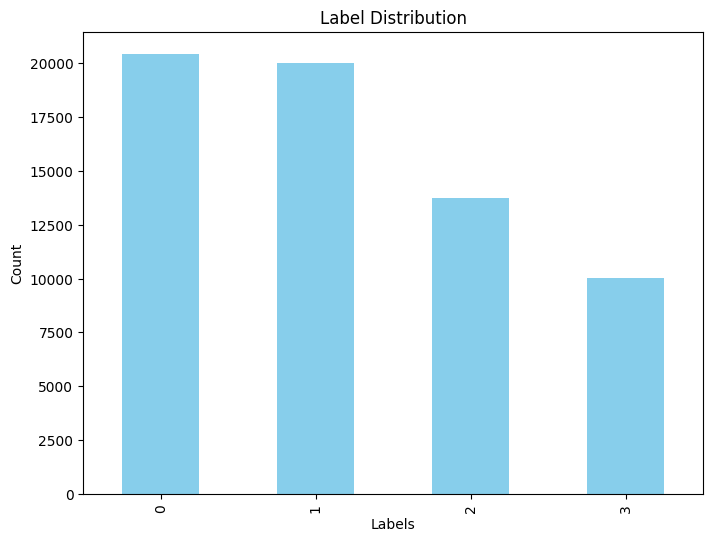

In [ ]:
# Assuming 'dev_labels' contains the labels for your development set
unique_labels, label_counts = np.unique(dev_labels, return_counts=True)
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution in Development Set')
plt.show()

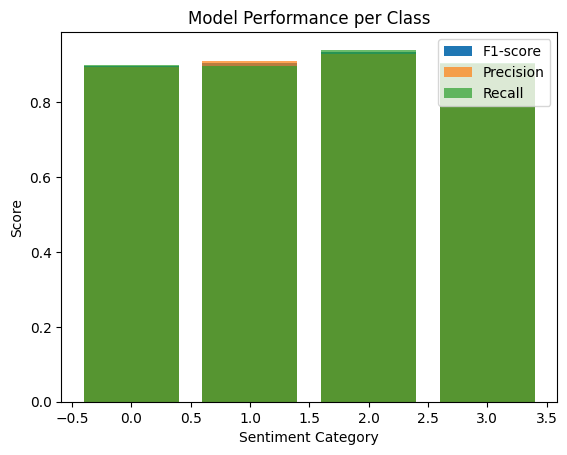

In [ ]:
from sklearn.metrics import precision_recall_fscore_support


precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, Last_predictions, labels=unique_labels)

plt.bar(unique_labels, f1, label='F1-score')
plt.bar(unique_labels, precision, label='Precision', alpha=0.7)
plt.bar(unique_labels, recall, label='Recall', alpha=0.7)
plt.xlabel('Sentiment Category')
plt.ylabel('Score')
plt.title('Model Performance per Class')
plt.legend()
plt.show()

In [ ]:
f1_scores = {'Validation Set': indiv_F1_validation, 'Test Set': indiv_F1_test}
plt.figure(figsize=(8, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'green'])
plt.title('F1-Score on Validation and Test Sets')
plt.ylabel('F1-Score (%)')
plt.show()

NameError: name 'indiv_F1_validation' is not defined